# Hotel Description Generation

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

In [2]:
import tensorflow as tf
tf.__version__

'2.2.0'

In [0]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Embedding

In [0]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow.keras.utils as ku

In [0]:
df=pd.read_csv('/content/drive/My Drive/Colab Notebooks/Datasets/Seattle_Hotels.csv',encoding="latin-1")

In [6]:
df.head()

,name,address,desc
0,Hilton Garden Inn Seattle Downtown,"1821 Boren Avenue, Seattle Washington 98101 USA","Located on the southern tip of Lake Union, the..."
1,Sheraton Grand Seattle,"1400 6th Avenue, Seattle, Washington 98101 USA","Located in the city's vibrant core, the Sherat..."
2,Crowne Plaza Seattle Downtown,"1113 6th Ave, Seattle, WA 98101","Located in the heart of downtown Seattle, the ..."
3,Kimpton Hotel Monaco Seattle,"1101 4th Ave, Seattle, WA98101",What?s near our hotel downtown Seattle locatio...
4,The Westin Seattle,"1900 5th Avenue, Seattle, Washington 98101 USA",Situated amid incredible shopping and iconic a...


In [7]:
df.shape

(152, 3)

In [8]:
df.isnull().sum()

name       0
address    0
desc       0
dtype: int64

In [0]:
text=df['desc']

In [10]:
text

0      Located on the southern tip of Lake Union, the...
1      Located in the city's vibrant core, the Sherat...
2      Located in the heart of downtown Seattle, the ...
3      What?s near our hotel downtown Seattle locatio...
4      Situated amid incredible shopping and iconic a...
                             ...                        
147    Located in Queen Anne district, The Halcyon Su...
148    Just a block from the world famous Space Needl...
149    Stay Alfred on Wall Street resides in the hear...
150    The perfect marriage of heightened convenience...
151    Yes, it's true. Every room at citizenM is the ...
Name: desc, Length: 152, dtype: object

# Preparing Text Data

In [0]:
cleaned_text=[]
for i in text:
  x=re.sub('[^.a-zA-Z]', ' ', i)
  cleaned_text.append(x)

## Tokenizing

In [0]:
tokenizer=Tokenizer(filters='!"#$%&()*+,-/:;<=>?@[\\]^_`{|}~\t\n')

In [0]:
tokenizer.fit_on_texts(cleaned_text)

In [0]:
word_index=tokenizer.word_index

In [15]:
vocab_size=len(word_index)+1
vocab_size

3535

## Creating Input Sequence

In [0]:
input_sequence=[]
for lines in cleaned_text:
  sequence=tokenizer.texts_to_sequences([lines])[0]
  for i in range (1,len(sequence)):
    ngrams=sequence[:i+1]
    input_sequence.append(ngrams)

In [0]:
max_len=max([len(lines) for lines in input_sequence])

In [18]:
max_len

507

## Padding Values

In [19]:
input_sequence=pad_sequences(input_sequence,maxlen=max_len)
input_sequence

array([[   0,    0,    0, ...,    0,   25,   21],
       [   0,    0,    0, ...,   25,   21,    1],
       [   0,    0,    0, ...,   21,    1, 1779],
       ...,
       [   0,    0,    0, ..., 1276,   54, 3533],
       [   0,    0,    0, ...,   54, 3533,   13],
       [   0,    0,    0, ..., 3533,   13, 3534]], dtype=int32)

## Creating Inputs and Labels

In [20]:
input_text=input_sequence[:,:-1]
input_text

array([[   0,    0,    0, ...,    0,    0,   25],
       [   0,    0,    0, ...,    0,   25,   21],
       [   0,    0,    0, ...,   25,   21,    1],
       ...,
       [   0,    0,    0, ..., 3532, 1276,   54],
       [   0,    0,    0, ..., 1276,   54, 3533],
       [   0,    0,    0, ...,   54, 3533,   13]], dtype=int32)

In [21]:
labels=input_sequence[:,-1]
labels

array([  21,    1, 1779, ..., 3533,   13, 3534], dtype=int32)

In [0]:
labels=ku.to_categorical(labels,num_classes=vocab_size)

## Globe Embedding

In [23]:
# This is the 100 dimension version of GloVe from Stanford
# I am using a api for faster access
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt \
    -O /tmp/glove.6B.100d.txt
embeddings_index = {};
with open('/tmp/glove.6B.100d.txt') as f:
    for line in f:
        values = line.split();
        word = values[0];
        coefs = np.asarray(values[1:], dtype='float32');
        embeddings_index[word] = coefs;

embeddings_matrix = np.zeros((vocab_size,100));
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word);
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector;

--2020-05-18 14:21:48--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.111.128, 2607:f8b0:4001:c23::80
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.111.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 347116733 (331M) [text/plain]
Saving to: ‘/tmp/glove.6B.100d.txt’

/tmp/glove.6B.100d. 100%[===================>] 331.04M   179MB/s    in 1.8s    

2020-05-18 14:21:50 (179 MB/s) - ‘/tmp/glove.6B.100d.txt’ saved [347116733/347116733]



## Building Model

In [0]:
model=Sequential()

In [0]:
model.add(Embedding(vocab_size,100,input_length=max_len-1,weights=[embeddings_matrix],trainable=False))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(128,return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(128)))
model.add(Dense(vocab_size,activation='softmax'))

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 506, 100)          353500    
_________________________________________________________________
dropout (Dropout)            (None, 506, 100)          0         
_________________________________________________________________
bidirectional (Bidirectional (None, 506, 256)          234496    
_________________________________________________________________
dropout_1 (Dropout)          (None, 506, 256)          0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               394240    
_________________________________________________________________
dense (Dense)                (None, 3535)              908495    
Total params: 1,890,731
Trainable params: 1,537,231
Non-trainable params: 353,500
________________________________________

In [0]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [28]:
history=model.fit(input_text,labels,epochs=80)

Epoch 1/80
759/759 [==============================] - 278s 366ms/step - loss: 6.6356 - accuracy: 0.0659
Epoch 2/80
759/759 [==============================] - 277s 365ms/step - loss: 6.0657 - accuracy: 0.0978
Epoch 3/80
759/759 [==============================] - 277s 364ms/step - loss: 5.6705 - accuracy: 0.1214
Epoch 4/80
759/759 [==============================] - 277s 365ms/step - loss: 5.3372 - accuracy: 0.1399
Epoch 5/80
759/759 [==============================] - 276s 364ms/step - loss: 5.0400 - accuracy: 0.1552
Epoch 6/80
759/759 [==============================] - 275s 363ms/step - loss: 4.7703 - accuracy: 0.1710
Epoch 7/80
759/759 [==============================] - 275s 363ms/step - loss: 4.5241 - accuracy: 0.1840
Epoch 8/80
759/759 [==============================] - 275s 362ms/step - loss: 4.3027 - accuracy: 0.1969
Epoch 9/80
759/759 [==============================] - 275s 362ms/step - loss: 4.0926 - accuracy: 0.2102
Epoch 10/80
759/759 [==============================] - 275s 362m

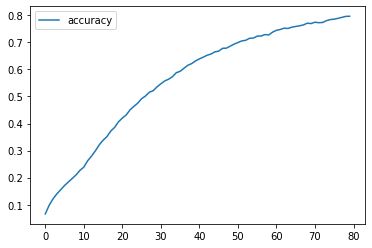

In [29]:
plt.plot(history.history['accuracy'],label='accuracy')
plt.legend()
plt.show()

## Generating Descriptions

In [0]:
def generate_text(next_words,new_text):
  for i in range(next_words):
    tokens=tokenizer.texts_to_sequences([new_text])
    padded_sequence=pad_sequences(tokens,maxlen=max_len-1)
    prediction=model.predict_classes(padded_sequence)
    for word,index in tokenizer.word_index.items():
      if index == prediction:
        output_word = word
        break
    new_text = new_text+' ' + output_word
  return new_text.title()

In [36]:
print(generate_text(100,"hilton seattle downtown"))

Hilton Seattle Downtown Sea Tac Airport South Is Accessible From I With Free Shuttle Service To Visit Of Sea Tac Airport Today Is An Extended Walk To The Washington State Convention Center Via The Underground Concourse. Hungry Visit Our Redtrees Restaurant Featuring Full Service Luxury Hotel And A Roomy Square Feet. Each Suite Includes A Private Bathroom A Separate Bedroom With Spacious Closets A Dining Area A Full Bath And Complete Kitchen Facilities Which Makes The University Motel Suites A Great Choice For Your Home Away From Home. At The University Motel Suites Each Of The Most Comfortable Beds And Suites With A


In [34]:
print(generate_text(150,'located in the heart of downtown seattle'))

Located In The Heart Of Downtown Seattle Hyatt Regency Seattle Is Just A Five Minute Walk From The Washington State Convention Center. Stay Within A Mile Of Seattle S Must See Attractions Including The Space Needle Chihuly Garden And Glass Pike Place Market And More. From Your Room Admire Stunning Views Through Floor To Ceiling Windows. Step Into Our Guest Rooms A King Bed With Plush Beds And Breakfast In The Courtyard. Entertain In Our Provenance Lounge With A Relaxing Retreat. Worked In The Hour Suite Includes A Swimming Pool Spa And Fitness Center Or Enjoy The Fitness Center And A Host Of Diverse Restaurants And Entertainment Venues Such As The Pacific Northwest Has To Offer. Historically By The Pacific Northwest Has To Offer. Historically By The Pacific Northwest. And Has Made Made The Community Banana Stand. As Seattle S Original Chef Derek Simcik You Ll Find Doing Easy Easy Access To Major Freeways Such Light Rail


In [35]:
print(generate_text(300,"best western seattle airport hotel"))

Best Western Seattle Airport Hotel In The Heart Of Downtown At Hilton Seattle. Our Upscale Residential Style Hotel Is Conveniently Located In The Fremont Neighborhood Off I And Exit From The Heart Of Downtown Seattle. Our Upscale Residential Style Hotel Is Conveniently Located In The Quiet Of Downtown Seattle. Our Hotel Is Near The Area S Oldest Attractions. Hall The Inn At The Wac House The Inn Operated As An Apartment Hotel For Many Years. Gradually As Long Term Tenants Moved Out The Hospital Began To Operate The Facility As A Limited Service Hotel For Patients Of The Hospital In One Of America S Most Dynamic Cities. It S A Place Where Travelers Become Residents And Residents Are Transported With Revelry Fueled By Executive Chef Derek Simcik S Dining Experiences. His Culinary Vision Pays Homage To The Bounty Of The Pacific Northwest Adding Intriguing Layers To The Choreography Of Your Stay. At The Maxwell Hotel We Pride Ourselves On Offering Only The Family Of Its Kind Neighborhood Y

## Model Generates quite good description with few grammatical errors, Which can be improved by training the model for a more number of epochs.
#### Training takes a huge amount of time as text size is quite large.